In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

2024-11-02 14:51:12.447495: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-02 14:51:12.459557: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1730559072.473927    1645 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1730559072.478168    1645 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-02 14:51:12.492120: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
import tensorflow as tf
import os

DATASET_DIR = 'dataset' 

# Đường dẫn tới các thư mục lớp
class_names = ['High squamous intra-epithelial lesion', 'Low squamous intra-epithelial lesion', 'Negative for Intraepithelial malignancy', 'Squamous cell carcinoma']
data_dir = os.path.join(DATASET_DIR)

BATCH_SIZE = 64
IMG_SIZE = (224, 224)

# Tạo dataset cho training và validation
train_dataset = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2, 
    subset="training",    
    seed=123,              
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    label_mode='categorical'
)

validation_dataset = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,  
    subset="validation",   
    seed=123,              
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    label_mode='categorical'
)


Found 962 files belonging to 4 classes.
Using 770 files for training.
Found 962 files belonging to 4 classes.
Using 192 files for validation.


2024-11-02 14:51:13.901026: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [3]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(max(1, val_batches // 5))
validation_dataset = validation_dataset.skip(max(1, val_batches // 5))

In [4]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 2
Number of test batches: 1


In [5]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [6]:
# Thay preprocess_input của EfficientNetB0
preprocess_input = tf.keras.applications.mobilenet_v3.preprocess_input

In [7]:
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1) # [-1, 1] or [0, 1]

In [8]:

# Create the base model from the pre-trained model MobileNet
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV3Large(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

12683000/12683000 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [9]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(64, 7, 7, 960)


In [10]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(64, 7, 7, 960)


In [11]:
base_model.trainable = False

In [12]:
base_model.summary()

Model: "MobileNetV3Large"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv (Conv2D)       │ (None, 112, 112,  │        432 │ rescaling_1[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_bn             │ (None, 112, 112,  │         64 │ conv[0][0]        │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 112, 112,  │          0 │ conv_bn[0][0]     │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        144 │ activation[0][0]  │
│ (DepthwiseConv2D)   │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │         64 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        256 │ re_lu[0][0]       │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_add   │ (None, 112, 112,  │          0 │ activation[0][0], │
│ (Add)               │ 16)               │            │ expanded_conv_pr… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_ex… │ (None, 112, 112,  │      1,024 │ expanded_conv_ad… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_ex… │ (None, 112, 112,  │        256 │ expanded_conv_1_… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 112, 112,  │          0 │ expanded_conv_1_… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_de… │ (None, 113, 113,  │          0 │ re_lu_1[0][0]     │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_de… │ (None, 56, 56,    │        576 │ expanded_conv_1_… │
│ (DepthwiseConv2D)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_de… │ (None, 56, 56,    │        256 │ expanded_conv_1_

 Total params: 2,996,352 (11.43 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,996,352 (11.43 MB)

In [13]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(64, 960)


In [14]:
prediction_layer = tf.keras.layers.Dense(4, activation='softmax')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(64, 4)


In [15]:
inputs = tf.keras.Input(shape=(224, 224, 3))
# x = data_augmentation(inputs)
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [16]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MobileNetV3Large (Functional)   │ (None, 7, 7, 960)      │     2,996,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 960)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 960)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │         3,844 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,000,196 (11.44 MB)

 Trainable params: 3,844 (15.02 KB)

 Non-trainable params: 2,996,352 (11.43 MB)

In [17]:
len(model.trainable_variables)

2

In [18]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(),  # Hoặc SparseCategoricalCrossentropy
              metrics=[tf.keras.metrics.CategoricalAccuracy(name='accuracy')])  # Hoặc SparseCategoricalAccuracy

In [19]:
initial_epochs = 100

loss0, accuracy0 = model.evaluate(validation_dataset)

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 104ms/step - accuracy: 0.1042 - loss: 3.2894


In [20]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 3.29
initial accuracy: 0.12


In [21]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,        
    patience=5,             
    verbose=1,             
    mode='auto',
    restore_best_weights=True 
)

In [22]:

history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset,
                    callbacks=[early_stopping])

Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 206ms/step - accuracy: 0.1143 - loss: 3.4724 - val_accuracy: 0.1328 - val_loss: 2.7748
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 200ms/step - accuracy: 0.1180 - loss: 2.8066 - val_accuracy: 0.1328 - val_loss: 2.1737
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 212ms/step - accuracy: 0.1466 - loss: 2.2144 - val_accuracy: 0.2656 - val_loss: 1.6582
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 202ms/step - accuracy: 0.2573 - loss: 1.7527 - val_accuracy: 0.3281 - val_loss: 1.4339
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 202ms/step - accuracy: 0.3683 - loss: 1.5228 - val_accuracy: 0.5234 - val_loss: 1.1757
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 200ms/step - accuracy: 0.4587 - loss: 1.3759 - val_accuracy: 0.5000 - val_loss: 1.2577
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 208ms/step - accuracy: 0.5423 - loss: 1.1616 - val_accuracy: 0.5938 - val_loss: 1.1304
Epoch 8/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 208ms/step - accuracy: 0.5624 - loss: 1.1663 - val_accu

In [23]:
actual_initial_epochs = len(history.epoch) 

In [24]:
actual_initial_epochs

35

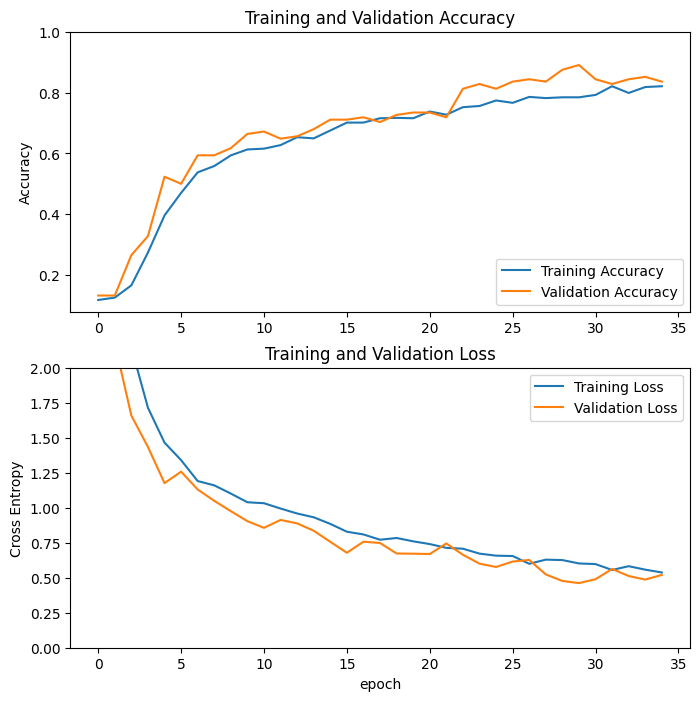

In [25]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,2.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [26]:
base_model.trainable = True

In [28]:
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 108

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  187


In [29]:
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),  # Hoặc tf.keras.losses.SparseCategoricalCrossentropy()
              optimizer=tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=[tf.keras.metrics.CategoricalAccuracy(name='accuracy')])

In [30]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MobileNetV3Large (Functional)   │ (None, 7, 7, 960)      │     2,996,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 960)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 960)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │         3,844 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,000,196 (11.44 MB)

 Trainable params: 2,106,700 (8.04 MB)

 Non-trainable params: 893,496 (3.41 MB)

In [31]:
# Set up callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',       
    patience=5,            
    verbose=1,               
    mode='auto',
    restore_best_weights=True 
)

# Save the model checkpoints
model_checkpoint = ModelCheckpoint(
    filepath='mobileNetV3_Large.keras',
    monitor='val_loss',
    verbose=1,             
    save_best_only=True,   
    save_weights_only=False, 
    mode='min',            
    save_freq='epoch'    
)

In [32]:
fine_tune_epochs = 100
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=actual_initial_epochs,
                         validation_data=validation_dataset,
                         callbacks=[early_stopping, model_checkpoint])

Epoch 36/200
12/13 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step - accuracy: 0.6733 - loss: 0.8656
Epoch 36: val_loss improved from inf to 0.58389, saving model to mobileNetV3_Large.keras
13/13 ━━━━━━━━━━━━━━━━━━━━ 10s 339ms/step - accuracy: 0.6750 - loss: 0.8592 - val_accuracy: 0.8125 - val_loss: 0.5839
Epoch 37/200
12/13 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step - accuracy: 0.6970 - loss: 0.7814
Epoch 37: val_loss did not improve from 0.58389
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 236ms/step - accuracy: 0.6985 - loss: 0.7731 - val_accuracy: 0.8125 - val_loss: 0.5948
Epoch 38/200
12/13 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step - accuracy: 0.7395 - loss: 0.6141
Epoch 38: val_loss improved from 0.58389 to 0.46434, saving model to mobileNetV3_Large.keras
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 267ms/step - accuracy: 0.7366 - loss: 0.6201 - val_accuracy: 0.8516 - val_loss: 0.4643
Epoch 39/200
12/13 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step - accuracy: 0.7534 - loss: 0.5858
Epoch 39: val_loss did not improve from 0.46434
13/13 ━━━━━━━━━━━━

In [33]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

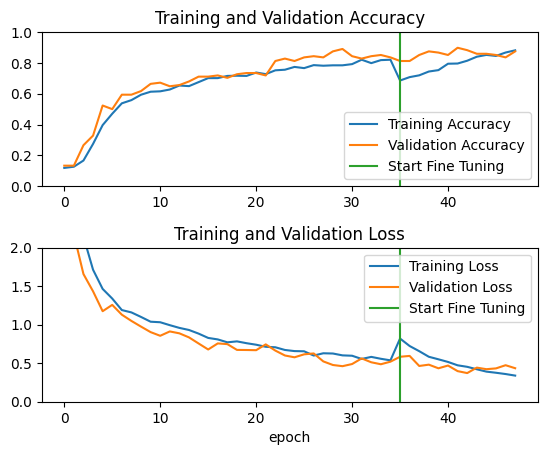

In [34]:
# Đồ thị Accuracy
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.plot([actual_initial_epochs, actual_initial_epochs], plt.ylim(), label='Start Fine Tuning')  # Đường chỉ điểm tại epoch thực tế
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Đồ thị Loss
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 2.0])
plt.plot([actual_initial_epochs, actual_initial_epochs], plt.ylim(), label='Start Fine Tuning')  # Đường chỉ điểm tại epoch thực tế
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')

plt.subplots_adjust(hspace=0.4) 
plt.show()

In [35]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step - accuracy: 0.8438 - loss: 0.4762
Test accuracy : 0.84375


Predictions:
 [1 0 0 0 0 1 0 0 1 0 0 0 0 0 1 0 0 1 0 0 0 0 1 0 0 0 1 0 0 1 0 0 0 0 1 0 1
 0 0 0 0 0 1 0 1 0 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0
 1 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 1 0 1 0 0 0 0 0 1 0 0 0 1 0 0 0 1
 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 1 0 1 0 0 0 0 0 1 0 0 0 1 0
 0 0 1 0 0 0 1 0 1 0 0 0 1 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 1 0 0 1 0 0 0
 0 0 0 0 0 1 0 0 0 1 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 1 0 0 0
 1 0 1 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 1 0 1 0 0 0 0 1 0 0 0 1 0 0]
Labels:
 [[1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0.

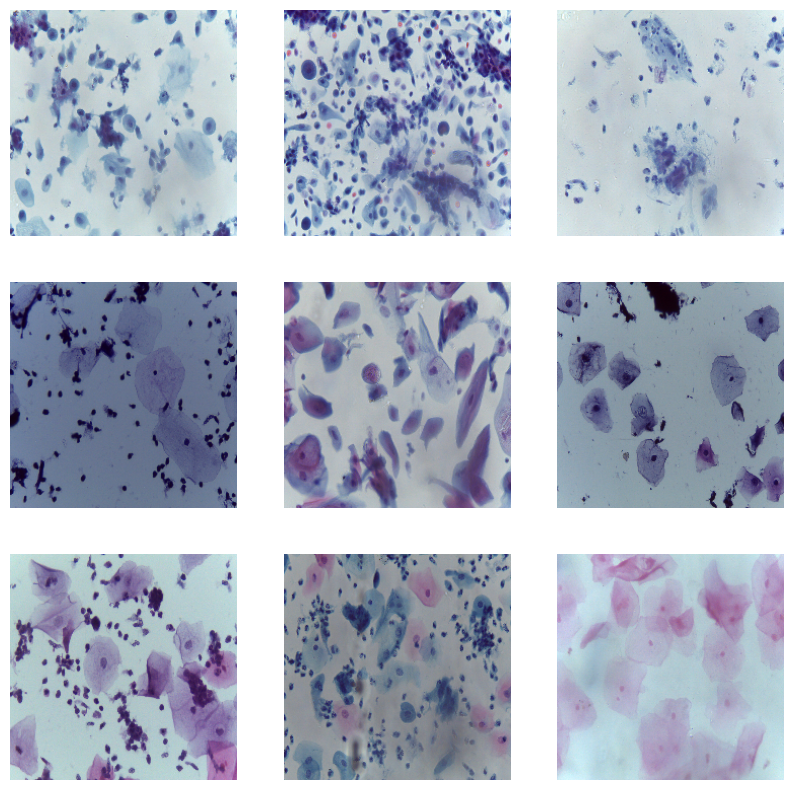

In [36]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
#   plt.title(class_names[predictions[i]])
  plt.axis("off")